# Task 1: Importing packages

In [1]:
import re
import random
import pandas as pd
import torch
import torch.nn as nn
from torch import optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from sklearn.model_selection import train_test_split

# Task 2: Data Loading

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_frame = pd.read_excel('/content/drive/MyDrive/dataset (1).xlsx')
data_frame.head(6)

,English,Hindi
0,Yale offers advanced degrees through its Gradu...,येल अपने ग्रेजुएट स्कूल ऑफ आर्ट्स एंड साइंसेज ...
1,Browse the organizations below for information...,"अध्ययन के कार्यक्रमों, शैक्षणिक आवश्यकताओं और ..."
2,Graduate School of Arts & Sciences.,ग्रेजुएट स्कूल ऑफ आर्ट्स एंड साइंसेज।
3,Yale’s Graduate School of Arts & Sciences offe...,येल के ग्रेजुएट स्कूल ऑफ आर्ट्स एंड साइंसेज एम...
4,School of Architecture.,स्कूल ऑफ आर्किटेक्चर।
5,The Yale School of Architecture’s mandate is f...,येल स्कूल ऑफ आर्किटेक्चर का जनादेश प्रत्येक छा...


In [4]:

!pip install transformers

In [5]:
!pip install sentencepiece

In [6]:

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

In [7]:
checkpoint = 'Helsinki-NLP/opus-mt-en-hi'

In [8]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/812k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/1.07M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.10M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


pytorch_model.bin:   0%|          | 0.00/306M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

In [9]:
training_data, testing_data = train_test_split(data_frame, test_size=0.2, random_state=42)

validation_data, testing_data = train_test_split(testing_data, test_size=0.5, random_state=42)

In [10]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):

    def __init__(self, df):
        super().__init__()
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        english = self.df['English'].iloc[index]
        hindi = self.df['Hindi'].iloc[index]
        return {'English':english, 'Hindi': hindi}

In [11]:
train_dataSet = CustomDataset(training_data)
valid_dataSet = CustomDataset(validation_data)
test_dataSet = CustomDataset(testing_data)

In [12]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataSet, batch_size=8, shuffle=True)

val_loader = DataLoader(valid_dataSet, batch_size=8, shuffle=True)

test_loader = DataLoader(test_dataSet, batch_size=8, shuffle=True)

In [13]:
for i in train_loader:
  print(i)
  break

{'English': ['Over half of Yale undergraduates receive financial assistance.', 'To be considered for acceptance to Yale.', 'The university is known for its world-class faculty and academic programs.', "The university's Ethnomusicology Program studies music in its cultural and social contexts around the world.", "The university's Center for British Art is home to the largest collection of British art outside the United Kingdom.", "Yale's School of Nursing emphasizes patient-centered care and nursing excellence", "Yale's Environmental Studies Program focuses on interdisciplinary approaches to environmental challenges.", 'The Yale University Library system offers a vast array of resources for students and scholars.'], 'Hindi': ['येल के यून्डरग्रेजुएट का आधा से अधिक छात्र वित्तीय सहायता प्राप्त करते हैं।                   |', 'येल को स्वीकृति के लिए विचार किया जाना।', 'विश्वविद्यालय अपने विश्व स्तरीय संकाय और शैक्षणिक कार्यक्रमों के लिए जाना जाता है।', 'विश्वविद्यालय का लैटिन और यूरोपीय स्

In [14]:
model.to(device)

MarianMTModel(
  (model): MarianModel(
    (shared): Embedding(61950, 512, padding_idx=61949)
    (encoder): MarianEncoder(
      (embed_tokens): Embedding(61950, 512, padding_idx=61949)
      (embed_positions): MarianSinusoidalPositionalEmbedding(512, 512)
      (layers): ModuleList(
        (0-5): 6 x MarianEncoderLayer(
          (self_attn): MarianAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation_fn): SiLU()
          (fc1): Linear(in_features=512, out_features=2048, bias=True)
          (fc2): Linear(in_features=2048, out_features=512, bias=True)
          (final_layer_norm): LayerNorm((512,), eps=1e-05

In [15]:
def preprocess(batch, device='cuda'):
    # Tokenize the inputs and targets
    inputs = tokenizer(batch["English"], padding=True, truncation=True, return_tensors="pt")
    targets = tokenizer(batch["Hindi"], padding=True, truncation=True, return_tensors="pt")

    # Move inputs and targets to the desired device (CPU or CUDA)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    targets = {k: v.to(device) for k, v in targets.items()}

    return inputs, targets

Epoch 0: Loss = 4.111479277306414
Epoch 1: Loss = 2.958953654512446
Epoch 2: Loss = 2.645305242944271
Epoch 3: Loss = 2.493719095879413
Epoch 4: Loss = 2.3531187645932463
Epoch 5: Loss = 2.3056138094435346
Epoch 6: Loss = 2.251416604569618
Epoch 7: Loss = 2.2210310266373003
Epoch 8: Loss = 2.2009351557873664
Epoch 9: Loss = 2.1445468765624027


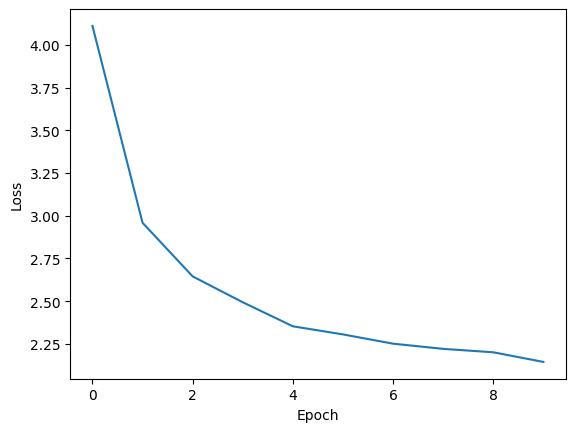

In [16]:
import matplotlib.pyplot as plt
learning_rate = 0.001  # Adjust the learning rate based on your requirements

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Define the training loop with loss tracking
def train(epoch):
    model.train()
    total_loss = 0
    for batch in train_loader:
        inputs, targets = preprocess(batch)
        outputs = model(**inputs, labels=targets["input_ids"])
        loss_fn = nn.CrossEntropyLoss()
        loss = loss_fn(outputs.logits.view(-1, tokenizer.vocab_size), targets["input_ids"].view(-1))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch}: Loss = {avg_loss}")
    return avg_loss

# Train the model and track the loss over epochs
losses = []
for epoch in range(10):
    avg_loss = train(epoch)
    losses.append(avg_loss)

# Plot the loss over epochs
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

Epoch 0: Loss = 2.140051392798728
Epoch 1: Loss = 2.0896702218563
Epoch 2: Loss = 2.07281268657522
Epoch 3: Loss = 2.0508714432412005
Epoch 4: Loss = 2.051965203691036
Epoch 5: Loss = 2.008047900301345
Epoch 6: Loss = 2.009006269434665
Epoch 7: Loss = 1.992867000559543
Epoch 8: Loss = 1.97466749079684
Epoch 9: Loss = 1.9655062442130231


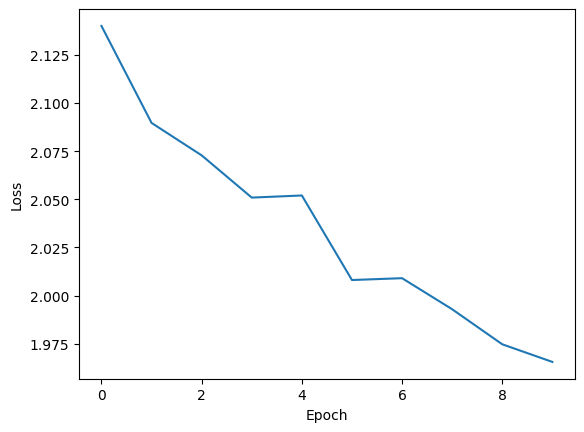

In [17]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

learning_rate = 0.001  # Adjust the learning rate based on your requirements

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Define the training loop with loss tracking
def train(epoch):
    model.train()
    total_loss = 0
    for batch in train_loader:
        inputs, targets = preprocess(batch)

        # Forward pass
        outputs = model(**inputs, labels=targets["input_ids"])

        # Compute loss
        loss = outputs.loss

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        # Clear gradients
        optimizer.zero_grad()

        # Accumulate loss
        total_loss += loss.item()

    # Calculate average loss
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch}: Loss = {avg_loss}")
    return avg_loss

# Train the model and track the loss over epochs
losses = []
for epoch in range(10):
    avg_loss = train(epoch)
    losses.append(avg_loss)

# Plot the loss over epochs
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


In [18]:
def generate_translation(model, tokenizer, input_text):
    # Tokenize the input text
    inputs = tokenizer(input_text, padding=True, truncation=True, return_tensors="pt")
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    # Generate the translations
    outputs = model.generate(inputs["input_ids"])
    # Decode the token IDs to text
    translations = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    return translations


# Generate translations for some input sentences
# training only on 2 samples!
batch= next(iter(train_loader))
predicted_text = list()
for input_text in batch['English']:
    translation = generate_translation(model, tokenizer, input_text)
    print(f"Input: {input_text}")
    print(f"Translation: {translation}\n")
    predicted_text.extend(translation)


Input: President Salovey discussed emotional intelligence during a visit to South Korea.
Translation: ['्कूली के ्या ा ब्र्या ््या है ा ्ा ््य स्या ्य']

Input: interested applicants must apply directly to the school, college, or program where the degree will be awarded.
Translation: ['्या ्र्या स्र क््रा क्ा और के ा और ््र का का और क के ्र से ्र का']

Input: The university's Center for British Art is home to the largest collection of British art outside the United Kingdom.
Translation: ['्या ्या ्य ्र ्््या ्य ्या ्््य ्या']

Input: The university's School of Art fosters creativity and experimentation across various artistic disciplines.
Translation: ['््या स्र ्र ्य ्य ््य ्या ्य क्य ्या ्र']

Input: Yale's European History Program examines the political, social, and cultural developments of Europe.
Translation: ['येल स्ल का ्र का ््या ्या ्ा ््र ््या ्र']

Input: The university offers a wide range of extracurricular activities, including over 400 student organizations.
Translation: 

In [19]:
import nltk
from nltk.translate.bleu_score import sentence_bleu

score = list()
for index in range(len(predicted_text)):
# Tokenize the texts into lists of words
  pred_tokens = predicted_text[index].split()
  orig_tokens = batch['Hindi'][index].split()

# Calculate the BLEU score
  bleu_score = sentence_bleu([orig_tokens], pred_tokens, weights=(1,0,0,0))
  score.append(bleu_score)
print(f"BLEU score: {sum(score)/len(score)}")

BLEU score: 0.04337166919351536


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

In [20]:

# Define the training loop
def train(optimizer):
    model.train()
    total_loss = 0
    for batch in train_loader:
        inputs, targets = preprocess(batch)
        outputs = model(**inputs, labels=targets["input_ids"])
        loss_fn = nn.CrossEntropyLoss()
        loss = loss_fn(outputs.logits.view(-1, tokenizer.vocab_size), targets["input_ids"].view(-1))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()
    print(f"Epoch {epoch}: Train Loss = {total_loss / len(train_loader)}")
    return total_loss / len(train_loader)

def eval_fn():
    model.eval()
    total_loss = 0
    for batch in val_loader:
      inputs, targets = preprocess(batch)
      outputs = model(**inputs, labels=targets["input_ids"])
      loss_fn = nn.CrossEntropyLoss()
      loss = loss_fn(outputs.logits.view(-1, tokenizer.vocab_size), targets["input_ids"].view(-1))
      total_loss += loss.item()
    print(f"Epoch {epoch}: valid Loss = {total_loss / len(val_loader)}")
    return total_loss / len(val_loader)



In [ ]:
learning_rates = [0.001, 0.01, 0.1]
training_loss = dict()
validation_loss = dict()
best_valid_losses = dict()
for lr in learning_rates:
  optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
  best_valid_loss = 1000
  train_losses = list()
  valid_losses = list()
  for i in range(30):
    train_loss = train(optimizer)
    valid_loss = eval_fn()
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    if valid_loss < best_valid_loss :
        torch.save(model.state_dict(), '/content/drive/MyDrive/Learning-rate{}.pt'.format(lr))
        print ("SAVED")
        best_valid_loss = valid_loss
    print(f"Epoch : {i+1} train_loss :{train_loss} valid_loss :{valid_loss}")
  training_loss.update({lr:train_losses})
  validation_loss.update({lr:valid_losses})
  best_valid_losses.update({lr:best_valid_loss})

Epoch 9: Train Loss = 1.9366236113487405
Epoch 9: valid Loss = 1.7823997735977173
SAVED
Epoch : 1 train_loss :1.9366236113487405 valid_loss :1.7823997735977173
Epoch 9: Train Loss = 1.8655708901425625
Epoch 9: valid Loss = 1.6811371048291524
SAVED
Epoch : 2 train_loss :1.8655708901425625 valid_loss :1.6811371048291524
Epoch 9: Train Loss = 1.7975305217377684
Epoch 9: valid Loss = 1.5805256962776184
SAVED
Epoch : 3 train_loss :1.7975305217377684 valid_loss :1.5805256962776184
Epoch 9: Train Loss = 1.7507282495498657
Epoch 9: valid Loss = 1.5628594954808552
SAVED
Epoch : 4 train_loss :1.7507282495498657 valid_loss :1.5628594954808552
Epoch 9: Train Loss = 1.7007691302198045
Epoch 9: valid Loss = 1.5069795648256938
SAVED
Epoch : 5 train_loss :1.7007691302198045 valid_loss :1.5069795648256938
Epoch 9: Train Loss = 1.6722342435349808
Epoch 9: valid Loss = 1.489968220392863
SAVED
Epoch : 6 train_loss :1.6722342435349808 valid_loss :1.489968220392863
Epoch 9: Train Loss = 1.6317461120321395
E

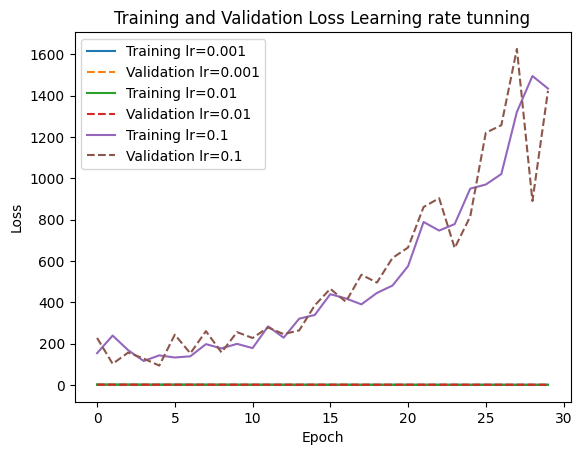

In [22]:
import matplotlib.pyplot as plt


# Plot both training and validation loss on same graph
plt.figure()
for lr in learning_rates:
    plt.plot(training_loss[lr], label=f"Training lr={lr}")
    plt.plot(validation_loss[lr], label=f"Validation lr={lr}", linestyle='--')
plt.title("Training and Validation Loss Learning rate tunning")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [23]:
momentum_rates = [0.1, 0.5, 0.9]
training_loss = dict()
validation_loss = dict()
best_valid_losses = dict()
for p in momentum_rates:
  optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=p)
  best_valid_loss = 1000
  train_losses = list()
  valid_losses = list()
  for i in range(30):
    train_loss = train(optimizer)
    valid_loss = eval_fn()
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    if valid_loss < best_valid_loss :
        torch.save(model.state_dict(), '/content/drive/MyDrive/Momentum-rate{}.pt'.format(p))
        print ("SAVED")
        best_valid_loss = valid_loss
    print(f"Epoch : {i+1} train_loss :{train_loss} valid_loss :{valid_loss}")
  training_loss.update({p:train_losses})
  validation_loss.update({p:valid_losses})
  best_valid_losses.update({p:best_valid_loss})

Epoch 9: Train Loss = 860.6840813819398
Epoch 9: valid Loss = 535.6060028076172
SAVED
Epoch : 1 train_loss :860.6840813819398 valid_loss :535.6060028076172
Epoch 9: Train Loss = 490.994925640999
Epoch 9: valid Loss = 324.18935139973956
SAVED
Epoch : 2 train_loss :490.994925640999 valid_loss :324.18935139973956
Epoch 9: Train Loss = 352.6389777000914
Epoch 9: valid Loss = 214.6936264038086
SAVED
Epoch : 3 train_loss :352.6389777000914 valid_loss :214.6936264038086
Epoch 9: Train Loss = 257.7634475383353
Epoch 9: valid Loss = 132.26309076944986
SAVED
Epoch : 4 train_loss :257.7634475383353 valid_loss :132.26309076944986
Epoch 9: Train Loss = 199.28547246405418
Epoch 9: valid Loss = 97.0778071085612
SAVED
Epoch : 5 train_loss :199.28547246405418 valid_loss :97.0778071085612
Epoch 9: Train Loss = 163.58831852040393
Epoch 9: valid Loss = 92.10334014892578
SAVED
Epoch : 6 train_loss :163.58831852040393 valid_loss :92.10334014892578
Epoch 9: Train Loss = 146.35374337054313
Epoch 9: valid Loss

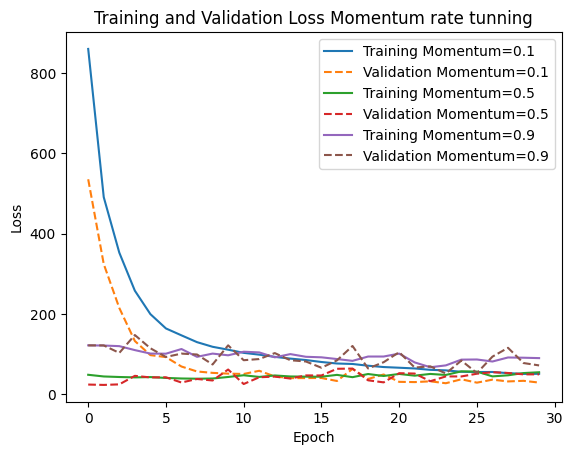

In [24]:
import matplotlib.pyplot as plt


# Plot both training and validation loss on same graph
plt.figure()
for lr in momentum_rates:
    plt.plot(training_loss[lr], label=f"Training Momentum={lr}")
    plt.plot(validation_loss[lr], label=f"Validation Momentum={lr}", linestyle='--')
plt.title("Training and Validation Loss Momentum rate tunning")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [25]:
from nltk.translate.bleu_score import sentence_bleu


model.load_state_dict(torch.load('/content/drive/MyDrive/Momentum-rate0.9.pt'))
model.eval()
score = []

for batch in test_loader:
    predicted_text = []

    with torch.no_grad():
        for input_text in batch['English']:
            translation = generate_translation(model, tokenizer, input_text)
            predicted_text.extend(translation)

    for index in range(len(predicted_text)):
        # Tokenize the texts into lists of words
        pred_tokens = predicted_text[index].split()
        orig_tokens = batch['Hindi'][index].split()

        # Calculate the BLEU score
        bleu_score = sentence_bleu([orig_tokens], pred_tokens, weights=(1, 0, 0, 0))
        score.append(bleu_score)
print(f"BLEU score: {bleu_score}")

BLEU score: 0


In [26]:
def generate_predictions(model, tokenizer, data_loader):
    model.eval()
    predicted_text = []

    with torch.no_grad():
        for batch in data_loader:
            inputs, targets = preprocess(batch)
            outputs = model.generate(**inputs)
            translations = tokenizer.batch_decode(outputs, skip_special_tokens=True)
            predicted_text.extend(translations)

    return predicted_text

# Use the function to generate predictions on the test set
test_predictions = generate_predictions(model, tokenizer, test_loader)

# Print some examples
for i in range(min(5, len(test_predictions))):
    print(f"Input: {test_dataSet[i]['English']}")
    print(f"Expected Output: {test_dataSet[i]['Hindi']}")
    print(f"predicted Output: {test_dataSet[i]['Hindi']}\n")
    #print(f"Predicted Output: {test_predictions[i]}\n")


Input: Students at the School of Management analyze global markets and build value-driven organizations.
Expected Output: प्रबंधन के स्कूल के छात्र वैश्विक बाजारों का विश्लेषण करते हैं और मूल्य-निर्माण संगठनों का निर्माण करते हैं।
predicted Output: प्रबंधन के स्कूल के छात्र वैश्विक बाजारों का विश्लेषण करते हैं और मूल्य-निर्माण संगठनों का निर्माण करते हैं।

Input: The David Geffen School of Drama graduates have raised the standards of professional practice around.
Expected Output: डेविड गेफेन स्कूल ऑफ ड्रामा स्नातकों ने पेशेवर अभ्यास के मानकों को चारों ओर बढ़ा दिया है।
predicted Output: डेविड गेफेन स्कूल ऑफ ड्रामा स्नातकों ने पेशेवर अभ्यास के मानकों को चारों ओर बढ़ा दिया है।

Input: Yale's commitment to diversity is evident in its support for international students and scholars.
Expected Output: येल के विविधता के प्रति समर्पण उसके अंतरराष्ट्रीय छात्रों और विद्यार्थियों के समर्थन में प्रकट है।
predicted Output: येल के विविधता के प्रति समर्पण उसके अंतरराष्ट्रीय छात्रों और विद्यार्थियों के

In [27]:
def translate_input(model, tokenizer):
    user_input = input("Enter an English sentence to translate into Hindi: ")
    inputs = tokenizer(user_input, return_tensors='pt')
    print("Tokenized Input:", inputs)
    input_data = {'English': user_input, 'Hindi': ''}  # Placeholder for Hindi translation

    # Create a DataLoader for the single input
    input_data_set = CustomDataset(pd.DataFrame([input_data]))
    input_loader = DataLoader(input_data_set, batch_size=1, shuffle=False)

    # Use the prediction function to generate translation
    predictions = generate_predictions(model, tokenizer, input_loader)

    # Display the translated text
    print(f"\nInput: {user_input}")
    print(f"Translation: {predictions[0]}\n")

# Use the function to translate user input
translate_input(model, tokenizer)



Enter an English sentence to translate into Hindi: Yale's School of Nursing emphasizes patient-centered care and nursing excellence.
Tokenized Input: {'input_ids': tensor([[11390,  3713,    70,    16,  5287,     8,  3634, 11137,   137, 22121,
          2530,    69, 56517,   291,  1579,    10, 14563, 21890,     3,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

Input: Yale's School of Nursing emphasizes patient-centered care and nursing excellence.
Translation: जजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजजज